# Imported modules

In [1]:
# %%file intel_images_cls_modules.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.autograd import Variable

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import time
import os
import copy
import PIL
import cv2
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix, classification_report
import shutil
import glob
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
import numpy as np
import random


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device= {device}')


torch.set_printoptions(linewidth=120)
print()
print('torch: ',torch.__version__)

Working on device= cuda

torch:  1.9.0+cu102


In [ ]:
# !pip install neptune-client
!pip install neptune-client torch torchvision

In [73]:
import neptune.new as neptune
from neptune.new.types import File

run = neptune.init(project='armin.derencz/Intel-Image-Classification',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NGIyYzQ2My1iZjBhLTQ1MGQtYTJlMS04YmMxODBhNWVjYTUifQ==',
                   source_files=['*.py'])

https://app.neptune.ai/armin.derencz/Intel-Image-Classification/e/IN-9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Kaggle data downloading

In [2]:
from google.colab import files
print("Please upload kaggle.json file.. \n")

upload = files.upload()

Please upload kaggle.json file.. 



Saving kaggle.json to kaggle.json


In [3]:
%%time
!pip install -U -q kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d puneet6060/intel-image-classification

 98% 341M/346M [00:03<00:00, 141MB/s]
100% 346M/346M [00:03<00:00, 116MB/s]
CPU times: user 116 ms, sys: 61.9 ms, total: 178 ms
Wall time: 8.17 s


# Classes preparing

In [58]:
# %%file data_wrangling.py

class DataWrangling:

  def __init__(self, path_to_zip_file):
    self.path_to_zip_file = path_to_zip_file

  def extract_archive(self):
    with ZipFile('intel-image-classification.zip', 'r') as zipobj:
      zipobj.extractall(path='data/')
      zipobj.close()

  def move_data_to_specific_dir(self, data_dir_path):
    for entry in os.scandir( data_dir_path ):
      if entry.is_dir():
        self.move_data_to_specific_dir(entry.path)
        path_to_data = glob.glob( entry.path + '/seg_*' )
        if path_to_data:
          if 'train' in path_to_data[0]:
            shutil.move( path_to_data[0], '/content/data/train/')

          elif 'test' in path_to_data[0]:
            shutil.move( path_to_data[0], '/content/data/val/')

          else:
            shutil.move( path_to_data[0], '/content/data/test/test/') # torchvision.datasets.ImageFolder expects subfolders
                                                                      # representing the classes containing images of the corresponding class.
  def del_directories(self, data_dir_path):
    dir_list_to_del = glob.glob( data_dir_path + '/seg_*' )
    [ shutil.rmtree(dir) for dir in dir_list_to_del ]

  def data_count(self, path):
    for self.entry in os.scandir( path= path ):
      if self.entry.is_dir():
        self.files_gen = ( self.image for self.image in os.listdir( self.entry.path ) )
        self.files_count = len( [ self.image for self.image in self.files_gen] )
        print( self.entry.name, self.files_count )

        if self.files_count >= 1:
          DataWrangling.data_count( self, path=self.entry.path )
    

In [59]:
# %%file image_preprocessing.py

class ImagePreprocessing:

  def __init__(self, dir_path):
    self.dir_path = dir_path
    self.counter = 0

  def __open_image_file(self, img):
    self.image_path = os.path.join( self.path, img )
    self.image = cv2.imread( self.image_path, cv2.IMREAD_UNCHANGED )
    self.image = cv2.cvtColor( self.image, cv2.COLOR_BGR2RGB)
    
  def image_size(self, class_name ):
    self.path = os.path.join( self.dir_path, class_name ) 
    self.files_gen = ( image for image in os.listdir( self.path ) )
    self.image = next( self.files_gen )
    self.__open_image_file( self.image )
    self.height, self.weight, _ = self.image.shape
    self.im_resolution = self.height, self.weight

    print(f'Size of images in class {class_name}: {self.im_resolution}')
   

  def __get_image_channels_as_array(self):
      self.__open_image_file( self.image )
      self.r_array, self.g_array, self.b_array  =  cv2.split( self.image )
      # convert to matrix
      # self.r_array, self.g_array, self.b_array  = np.asarray(self.r), np.asarray(self.g), np.asarray(self.b)
      return self.r_array, self.g_array, self.b_array 

  def __convert_to_float(self):
      # convert from int to float
      self.r_array, self.g_array, self.b_array = self.r_array.astype('float32'), self.g_array.astype('float32'), self.b_array.astype('float32')
      return self.r_array, self.g_array, self.b_array 

  def __normalize(self):
      # normalize to the range 0-1
      self.r_array /= 255.0
      self.g_array /= 255.0
      self.b_array /= 255.0
      return self.r_array, self.g_array, self.b_array 

  def __calculate_mean_and_std(self):
      # calculate mean
      self.r_array_mean, self.g_array_mean, self.b_array_mean = np.mean( self.r_array ), np.mean( self.g_array ), np.mean( self.b_array )
      # calculate std
      self.r_array_std, self.g_array_std, self.b_array_std = np.std( self.r_array ), np.std( self.g_array ), np.std( self.b_array )

  def __append_to_data_frame(self):
      param_dict = {  
                      'image'  : self.image_name,
                      'R_mean' : self.r_array_mean, 'G_mean' : self.g_array_mean, 'B_mean' : self.b_array_mean, 
                      'R_std'  : self.r_array_std,  'G_std'  : self.g_array_std,  'B_std'  : self.b_array_std  
                    }
      self.df = self.df.append( pd.DataFrame(param_dict, index=[0] ))     

  # /content/data/train   /content/data/train/buildings
  
  def get_mean_and_std_images(self, class_name ):
    self.df = pd.DataFrame() 
    self.path = os.path.join( self.dir_path, class_name ) 
    self.files_gen = ( self.image for self.image in os.listdir( self.path ) )
    for self.image in self.files_gen:
      self.image_name = self.image
      self.__get_image_channels_as_array()
      self.__convert_to_float()
      self.__normalize()
      self.__calculate_mean_and_std()
      self.__append_to_data_frame()
    self.df.reset_index( drop=True, inplace=True )
    return self.df

  def image_resize(self, folder_name, img_size ):

    self.files_gen = ( image for image in os.listdir( self.dir_path ) )
    self.width, self.height = image_size
    print(f'Resizing images to {self.width}x{self.height} pixels...')
    for self.counter, self.image in enumerate( self.files_gen ):
      self.file_path = os.path.join( self.path_to_folder, str(self.image) )
      self.__open_image_file( self.image )
      self.image = self.image.resize( img_size )
      self.image.save( fp=self.file_path, format='JPEG') 
      self.counter +=1
    print(f'{self.counter} files has been saved in directory')

  def visualize_n_random_images( self, number_of_images, no_rows, no_cols, set_figsize, class_name, save_to_path):
    self.i = 1
    self.images_no = number_of_images
    self.cols = no_cols
    self.rows = no_rows
    self.path = os.path.join( self.dir_path, class_name )
    self.files_gen = ( image for image in os.listdir( self.path ) )
    self.random_images = random.choices( list(self.files_gen), k=self.images_no )


    fig = plt.figure( figsize= set_figsize  )
    for self.image in self.random_images:
      self.image_name = self.image
      self.ax = fig.add_subplot( self.rows, self.cols, self.i)      
      self.__open_image_file( self.image )
      plt.imshow( self.image )  
      plt.axis('off')
      self.ax.set_title( self.image_name, color= 'green', fontweight='bold')
      fig.tight_layout()
      self.i+=1
    plt.savefig( save_to_path )

Writing image_preprocessing.py


In [6]:
class ModelTesting( ImagePreprocessing ):
  
  def __init__(self):
    pass

  def prediction(self, img_path,transformer):
      
      image=PIL.Image.open(img_path)
      
      image_tensor=transformer(image).float()
      image_tensor=image_tensor.unsqueeze_(0)
      input=Variable(image_tensor)
      input = input.to(device)
        
      output=model(input)
      index=output.data.cpu().numpy().argmax()
      
      pred=class_names[index]
      
      return pred


  def model_testing(self, images_dir ):

    pred_dict={}
    images_pathes = glob.glob( os.path.join( images_dir, '*.jpg') )

    for img_path in images_pathes:
      last_slash_idx        = img_path.rfind('/')
      img_name              = img_path[ last_slash_idx + 1: ]
      predicted_class       = prediction(img_path, transformer=data_transforms['test'])
      pred_dict[ img_name ] = predicted_class
    return pred_dict    

# Pathes to directory

In [6]:
path_to_zip = '/content/intel-image-classification.zip'

dir_path = '/content/data/'


class_names = [ 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street' ]

builiding_class = class_names[0]
forest_class    = class_names[1]
glacier_class   = class_names[2]
mountain_class  = class_names[3]
sea_class       = class_names[4]
street_class    = class_names[5]

# Instances declaration

In [7]:
# from image_preprocessing import ImagePreprocessing
data_wrangling_obj = DataWrangling( path_to_zip )

In [8]:
train_data = '/content/data/train'

train_images = ImagePreprocessing( dir_path=train_data)


# Data wrangling

In [9]:
data_wrangling_obj.extract_archive()
data_wrangling_obj.move_data_to_specific_dir( data_dir_path=dir_path )
data_wrangling_obj.del_directories( data_dir_path=dir_path )

In [10]:
data_wrangling_obj.data_count( path=dir_path)

val 6
mountain 525
street 501
buildings 437
sea 510
glacier 553
forest 474
train 6
mountain 2512
street 2382
buildings 2191
sea 2274
glacier 2404
forest 2271
test 1
test 7301


In [60]:
train_images.image_size( class_name=builiding_class ) 

Size of images in class buildings: (150, 150)


# Mean, STD, for each class and set

In [61]:
train_building_imgs_df   = train_images.get_mean_and_std_images( class_name=builiding_class )
train_forest_imgs_df    = train_images.get_mean_and_std_images( class_name=forest_class )
train_glacier_imgs_df   = train_images.get_mean_and_std_images( class_name=glacier_class )
train_mountain_imgs_df  = train_images.get_mean_and_std_images( class_name=mountain_class )
train_sea_imgs_df       = train_images.get_mean_and_std_images( class_name=sea_class )
train_street_imgs_df    = train_images.get_mean_and_std_images( class_name=street_class )

In [59]:
train_building_imgs_df

image    R_mean    G_mean    B_mean     R_std     G_std     B_std
0     10278.jpg  0.371336  0.391248  0.395409  0.342862  0.282866  0.258687
1      3028.jpg  0.441757  0.459501  0.457998  0.205156  0.222332  0.244292
2      4458.jpg  0.305436  0.264050  0.248412  0.168985  0.161238  0.139422
3      7994.jpg  0.475750  0.528202  0.600838  0.221698  0.214945  0.245165
4       448.jpg  0.715789  0.653833  0.591405  0.261456  0.246404  0.250863
...         ...       ...       ...       ...       ...       ...       ...
2186   3082.jpg  0.568310  0.568310  0.568310  0.151881  0.151881  0.151881
2187  17094.jpg  0.484913  0.480194  0.473729  0.222825  0.224100  0.229865
2188   8592.jpg  0.644198  0.633884  0.622419  0.293028  0.295820  0.305615
2189   9369.jpg  0.474498  0.430788  0.345737  0.267358  0.231128  0.233707
2190   8604.jpg  0.339309  0.228729  0.106943  0.197031  0.162403  0.121339

[2191 rows x 7 columns]

In [60]:
train_forest_imgs_df

image    R_mean    G_mean    B_mean     R_std     G_std     B_std
0     12630.jpg  0.215840  0.234512  0.191109  0.110699  0.116808  0.114320
1      9219.jpg  0.111978  0.181358  0.064870  0.122394  0.155696  0.097233
2     12739.jpg  0.286984  0.405363  0.249997  0.205397  0.198265  0.182459
3     17263.jpg  0.322833  0.427633  0.336046  0.163282  0.167927  0.163085
4     15741.jpg  0.242849  0.227634  0.106145  0.118535  0.121897  0.078052
...         ...       ...       ...       ...       ...       ...       ...
2266  10607.jpg  0.498237  0.469121  0.437452  0.193928  0.201727  0.215818
2267   5872.jpg  0.284502  0.358230  0.184865  0.204805  0.231126  0.191388
2268  12768.jpg  0.309815  0.391254  0.248081  0.185489  0.190933  0.186185
2269  12548.jpg  0.247620  0.211464  0.167255  0.253118  0.233826  0.219991
2270   4255.jpg  0.318557  0.490680  0.175851  0.243105  0.229271  0.228079

[2271 rows x 7 columns]

In [ ]:
train_forest_imgs_df

In [ ]:
train_glacier_imgs_df

In [ ]:
train_mountain_imgs_df

In [ ]:
train_sea_imgs_df

In [ ]:
train_street_imgs_df

In [74]:
# Pandas DataFrame 
run['data/train_building_images_channels_mean_std'].upload(File.as_html( train_building_imgs_df ))
run['data/train_forest_images_channels_mean_std'].upload(File.as_html( train_forest_imgs_df ))
run['data/train_glacier_images_channels_mean_std'].upload(File.as_html( train_glacier_imgs_df ))
run['data/train_mountain_images_channels_mean_std'].upload(File.as_html( train_mountain_imgs_df ))
run['data/train_sea_images_channels_mean_std'].upload(File.as_html( train_sea_imgs_df ))
run['data/train_street_images_channels_mean_std'].upload(File.as_html( train_street_imgs_df ))


# Images presentation

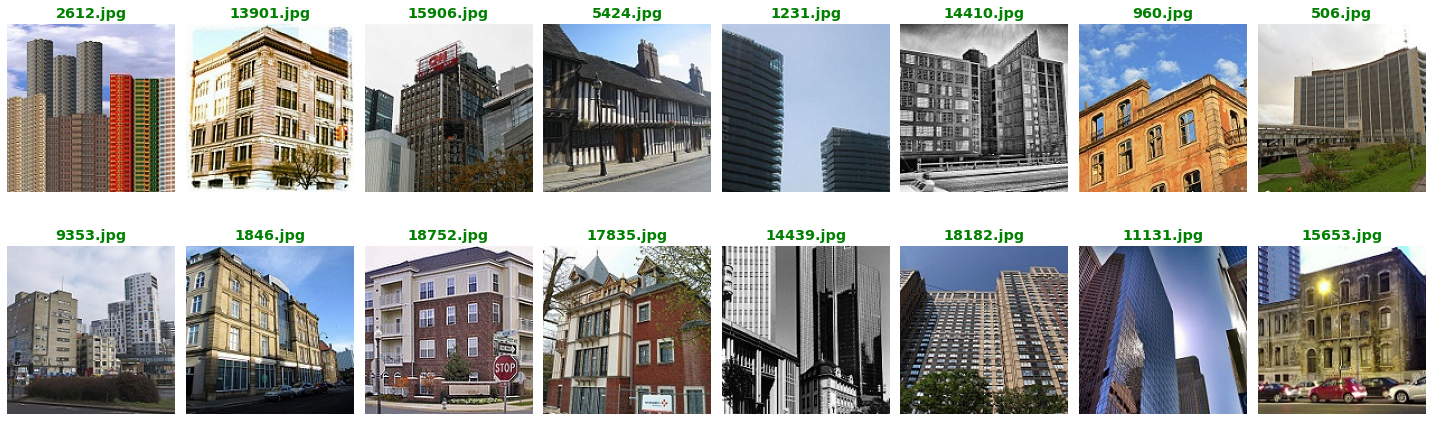

In [62]:
number_of_images=16
no_rows= 2
no_cols= 8
set_figsize= (20,8)

class_name= builiding_class
save_path ='./data/examples_of_buildings_images.jpg'


# number_of_images, no_rows, no_cols, set_figsize, img_name, set_dir, class_name, save_to_path

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

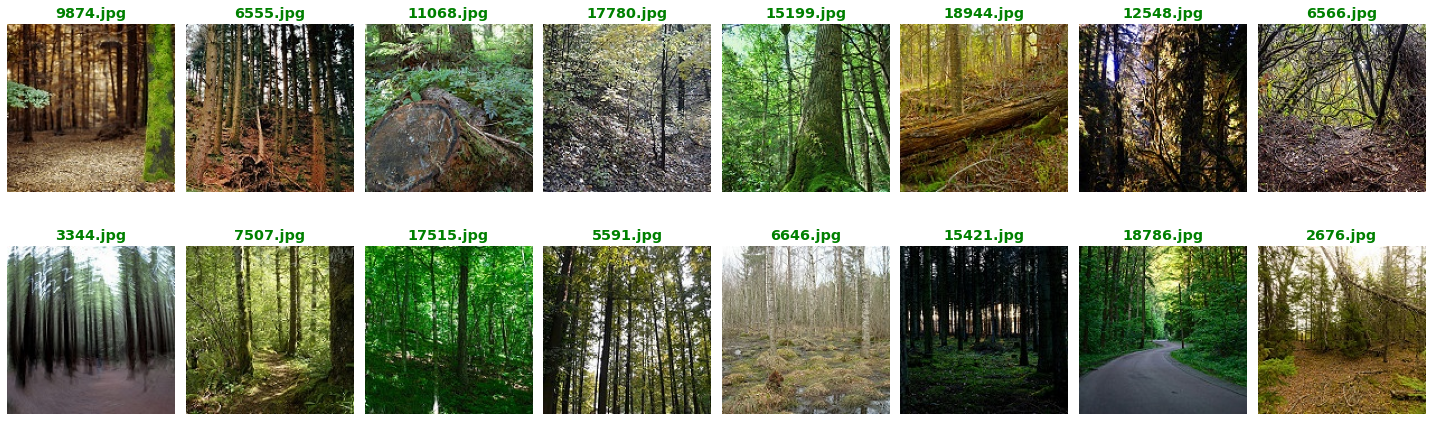

In [63]:
class_name= forest_class
save_path ='./data/examples_of_forest_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

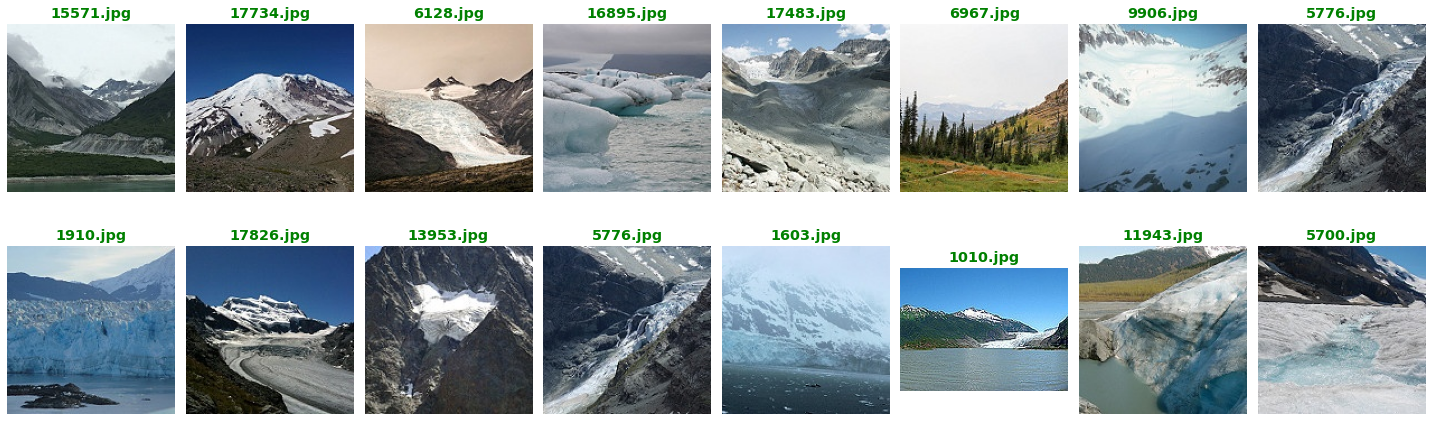

In [64]:
class_name= glacier_class
save_path ='./data/examples_of_glacier_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

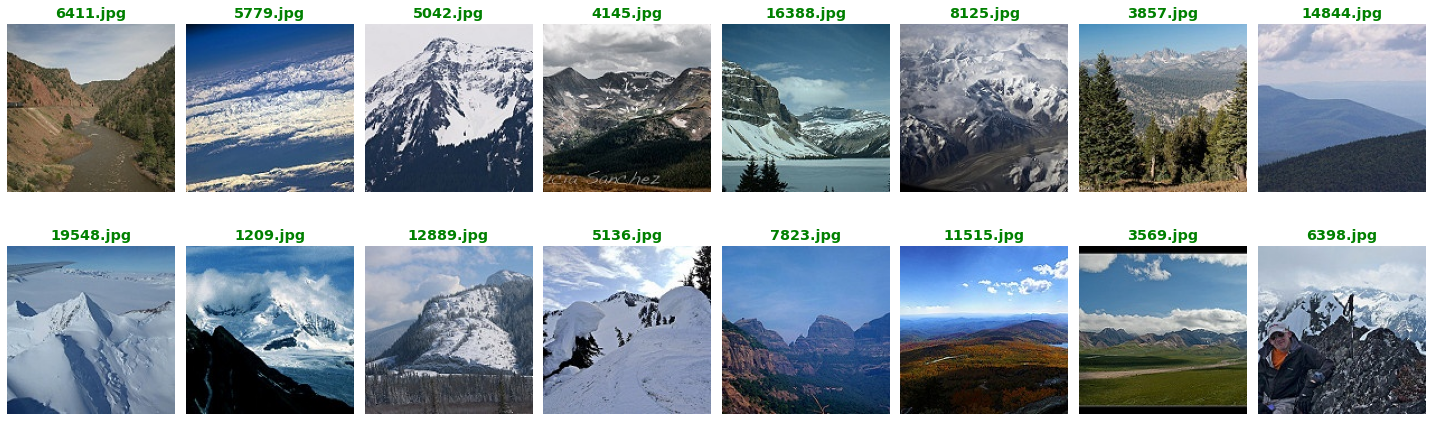

In [65]:
class_name= mountain_class
save_path ='./data/examples_of_mountain_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

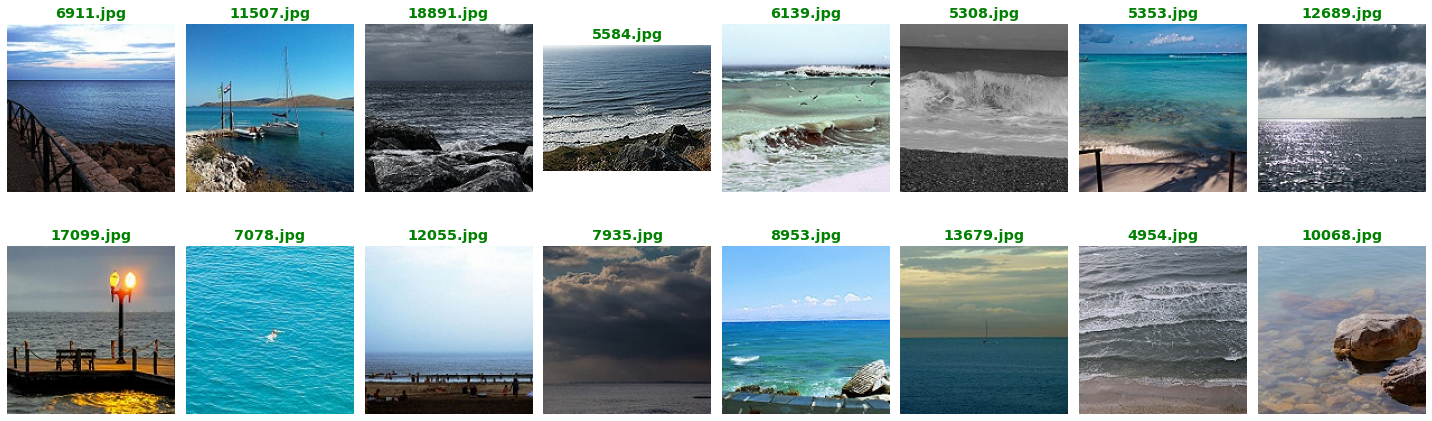

In [66]:
class_name= sea_class
save_path ='./data/examples_of_sea_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

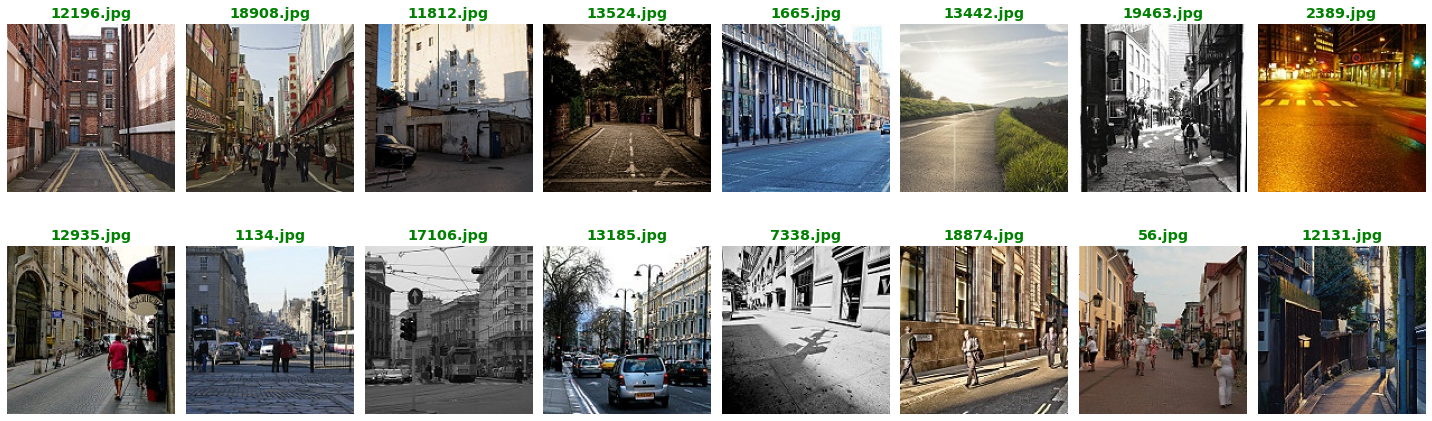

In [67]:
class_name= street_class
save_path ='./data/examples_of_street_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

In [75]:
run['images/train/examples_of_buildings_images'].upload('./data/examples_of_buildings_images.jpg')
run['images/train/examples_of_forest_images'].upload('./data/examples_of_forest_images.jpg')
run['images/train/examples_of_glacier_images'].upload('./data/examples_of_glacier_images.jpg')
run['images/train/examples_of_mountain_images'].upload('./data/examples_of_mountain_images.jpg')
run['images/train/examples_of_sea_images'].upload('./data/examples_of_sea_images.jpg')
run['images/train/examples_of_street_images'].upload('./data/examples_of_street_images.jpg')

In [68]:
# %%file data_transforms.py

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomHorizontalFlip()
    ]),
    'val': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])  
}

# run['config/dataset/transforms'] = data_transforms

Writing data_transforms.py


In [17]:
# import
data_dir = 'data'
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders    = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


torch.Size([4, 3, 150, 150]) torch.Size([4])


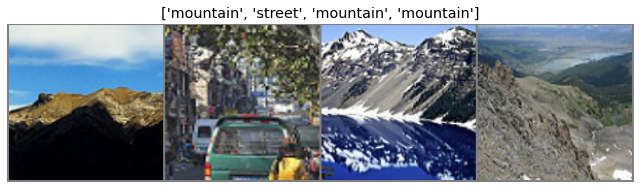

In [15]:
# This Data contains around 25k images of size 150x150 distributed under 6 categories.
# {'buildings' -> 0,
# 'forest' -> 1,
# 'glacier' -> 2,
# 'mountain' -> 3,
# 'sea' -> 4,
# 'street' -> 5 }

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure( figsize= ( 10, 8 )  )
    plt.imshow(inp)
   
    plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape, classes.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

img_exmp = imshow(out, title=[class_names[x] for x in classes])
# plt.imsave('img_exmp.jpg', img_exmp)

In [ ]:
# Opdpowiedź dlaczego jest  16*5*5 w __init__ fc1
conv1 = nn.Conv2d( in_channels=3, out_channels=12, kernel_size=5, stride=1 )
pool1 = nn.MaxPool2d(2, 2)   # 2x2 - kernel size, 2 - stride
conv2 = nn.Conv2d( in_channels=12, out_channels=20, kernel_size=3, stride=1 )
pool2 = nn.MaxPool2d(2, 2)
conv3 = nn.Conv2d( in_channels=20, out_channels=32, kernel_size=3, stride=1 )
pool3 = nn.MaxPool2d(2, 2)
    

print('Wzór: ( W -F + 2P)/S + 1')
print('example: 5x5 input, 3x3 filter, padding=0, stride=1')
print('(5-3 + 0)/1+1 = 2/1 +1 = 3 -> 3x3')
print()
print(f'{inputs.shape} -  4 batch size, 3 color channel, 150*150 image size')
print()

x = conv1( inputs )
print(f'{x.shape} - ze wzoru: ( 150 - 5 + 0 )/1 + 1 = 146 -> 146x146') 
x = pool1(x)
print(f'{x.shape} - ze wzoru: ( 146 - 2 + 0 )/2 + 1 = 73 -> 73x73 po pierwszym maxPool')  
x = conv2(x)
print(f'{x.shape} - ze wzoru: ( 73 - 3 + 0 )/1 + 1 = 71 -> 71x71') 
x = pool2(x)
print(f'{x.shape} - ze wzoru: ( 71 - 2 + 0 )/2 + 1 = 35 -> 35x35 po drugim maxPool')
x = conv3(x)
print(f'{x.shape} - ze wzoru: ( 35 - 3 + 0 )/1 + 1 = 33 -> 33x33')
x = pool2(x)
print(f'{x.shape} - ze wzoru: ( 33 - 2 + 0 )/2 + 1 = 16 -> 16x16 po trzecim maxPool')

print()
print('Na końcu chcemy otrzymać 1D wektor, dlatego mnożymy 32*16*16')

In [69]:
# %%file model_net.py 
class ConvNet(nn.Module):
  def __init__(self):  
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=3, out_channels=12, kernel_size=5, stride=1 )
        self.pool1 = nn.MaxPool2d(2, 2)  # 2x2 - kernel size, 2 - stride 
        self.conv2 = nn.Conv2d( in_channels=12, out_channels=20, kernel_size=3, stride=1 )
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.conv3 = nn.Conv2d( in_channels=20, out_channels=32, kernel_size=3, stride=1 )
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 120) # input size - 16*7*7, output size - 120
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 6) 


  def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool1(F.relu(self.conv1(x)))  # -> n, 6, 18, 18
        x = self.pool2(F.relu(self.conv2(x)))  # -> n, 16, 7, 7
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 32*16*16)            # -> n, 784 ( musimy wszystko spłaszczyć)
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

Writing model_net.py


In [18]:
dataloaders.keys()

dict_keys(['train', 'val'])

In [76]:
# Hyperparameters
input_size = 150*150
num_classes = 6
learning_rate = 0.001
batch_size = 100
num_epochs = 15


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# run['config/dataset/train_dataset'].track_files("./content/data/train")
# run['config/dataset/val_dataset'].track_files("./content/data/val")
# run['config/dataset/test_dataset'].track_files("./content/data/test")

In [77]:
hparams = {"learning_rate"  : learning_rate,
          "optimizer"      : type(optimizer).__name__,
          "criterion"      : type(criterion).__name__,
          "batch_size"     : batch_size,
          "n_epochs"       : num_epochs,
          "Input_size"    : "150 x 150",
          "n_classes" : num_classes,
          'metrics': ['accuracy']
          }


run["config/parameters"] = hparams
run['config/model'] = type(model).__name__

In [18]:
print( model.conv1.weight.shape)
print( model.conv2.weight.shape )
print( model.conv3.weight.shape )

torch.Size([12, 3, 5, 5])
torch.Size([20, 12, 3, 3])
torch.Size([32, 20, 3, 3])


In [78]:
summary(model, input_size=( 3, 150, 150 ) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 146, 146]             912
         MaxPool2d-2           [-1, 12, 73, 73]               0
            Conv2d-3           [-1, 20, 71, 71]           2,180
         MaxPool2d-4           [-1, 20, 35, 35]               0
            Conv2d-5           [-1, 32, 33, 33]           5,792
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Linear-7                  [-1, 120]         983,160
            Linear-8                   [-1, 84]          10,164
            Linear-9                    [-1, 6]             510
Total params: 1,002,718
Trainable params: 1,002,718
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 3.73
Params size (MB): 3.83
Estimated Total Size (MB): 7.81
---------------------------------------

# model function

In [80]:
# %%file train_model.py
class TrainModel:
  
  def __init__(self, model, criterion, optimizer, num_epochs, dataloaders, device):
    self.dataloaders = dataloaders
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.num_epochs = num_epochs
    self.train_loss_list = []
    self.train_acc_list  = []
    self.val_loss_list   = []
    self.val_acc_list    = []
    self.epochs_list     = []
    self.metrics_df = pd.DataFrame()
    self.device = device


  def __backpropagation_algorithm(self ):
    # forward
    # track history if only in train
    with torch.set_grad_enabled( self.phase == 'train'):
      self.outputs = self.model(self.inputs)
      _, preds = torch.max( self.outputs, 1)
      self.loss = self.criterion( self.outputs, self.labels)
      # backward and optimize only if in training phase
      if self.phase == 'train':
        self.optimizer.zero_grad()
        self.loss.backward() # calculate gradients
        self.optimizer.step() # update weights
    # statistics
    self.running_loss += self.loss.item() * self.inputs.size(0)
    self.running_corrects += torch.sum(preds == self.labels.data)

    return self.running_loss, self.running_corrects

  def __set_model_phase(self):
    if self.phase == 'train':
      self.model.train()  # Set model to training model
    else:
      self.model.eval()   # Set model to evaluate model

  def __loop_over_phase(self):
    # Each epoch has a training and validation phase
    for self.phase in self.dataloaders.keys():
      self.running_loss = 0.0
      self.running_corrects = 0
      self.__set_model_phase()
      # Iterate over data.
      for self.inputs, self.labels in self.dataloaders[self.phase]:
        self.inputs = self.inputs.to(self.device)
        self.labels = self.labels.to(self.device)
        # back propagation
        self.__backpropagation_algorithm()
      self.epoch_loss = self.running_loss / dataset_sizes[self.phase]
      self.epoch_accuracy = self.running_corrects.double() / dataset_sizes[self.phase]          
      print(f'{self.phase} -  Loss: {self.epoch_loss:.4f} Acc: {self.epoch_accuracy:.4f}')
      self.__metrics_saving()  
      print()
          
  def __metrics_saving(self):
    if self.phase == 'train':
      self.train_loss_list.append(self.epoch_loss)
      self.train_acc_list.append(self.epoch_accuracy.item())

      run["metrics/training/batch/loss"].log(self.loss)
      run["metrics/training/batch/acc"].log(self.epoch_accuracy.item())
    else:
      self.val_loss_list.append(self.epoch_loss)
      self.val_acc_list.append(self.epoch_accuracy.item()) 

      run["metrics/validation/batch/loss"].log(self.loss)
      run["metrics/validation/batch/acc"].log(self.epoch_accuracy.item())
            
      if self.epoch_accuracy > self.best_accuracy:
        self.best_accuracy = self.epoch_accuracy

    return  self.train_loss_list, self.train_acc_list, self.val_loss_list, self.val_acc_list, self.best_accuracy

  def __metrics_to_df(self):
    # global metrics_df
    
    print('Saving to data frame...')
    # np.column_stack rather than zip as in your first attempt, this has around a 2x speedup
    self.metrics_df = pd.DataFrame(np.column_stack([ self.epochs_list, self.train_loss_list, self.val_loss_list,
                                               self.train_acc_list, self.val_acc_list ]), 
                                columns=['epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])      
    self.metrics_df.reset_index(drop=True, inplace=True)

  def train_model(self):
    self.start = time.time()
    self.best_accuracy = 0.0

    for epoch in range( self.num_epochs):
      self.epochs_list.append( epoch + 1 )
      print(f'Epoch {epoch}/{ self.num_epochs - 1}')
      print('-' * 15)
      self.__loop_over_phase() 
    self.__metrics_to_df()
    self.time_elapsed = time.time() - self.start
    print(f'Training complete in {self.time_elapsed // 60:.0f}m {self.time_elapsed % 60:.0f}s')
    print('Best val Acc: {:4f}'.format(self.best_accuracy))
    # return self.model

In [81]:
intel_image_cls = TrainModel( model=model, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, dataloaders=dataloaders, device=device )

In [20]:
intel_image_cls.device

device(type='cuda', index=0)

In [82]:
intel_image_cls.optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [83]:
intel_image_cls.train_model()

Epoch 0/14
---------------
train -  Loss: 1.6804 Acc: 0.3091

val -  Loss: 1.3291 Acc: 0.4763

Epoch 1/14
---------------
train -  Loss: 1.2771 Acc: 0.4907

val -  Loss: 1.0975 Acc: 0.5480

Epoch 2/14
---------------
train -  Loss: 1.1557 Acc: 0.5356

val -  Loss: 0.9738 Acc: 0.6237

Epoch 3/14
---------------
train -  Loss: 1.0864 Acc: 0.5638

val -  Loss: 0.9994 Acc: 0.6173

Epoch 4/14
---------------
train -  Loss: 1.0394 Acc: 0.5938

val -  Loss: 0.8701 Acc: 0.6667

Epoch 5/14
---------------
train -  Loss: 1.0030 Acc: 0.6094

val -  Loss: 0.8445 Acc: 0.6920

Epoch 6/14
---------------
train -  Loss: 0.9605 Acc: 0.6296

val -  Loss: 0.7939 Acc: 0.7133

Epoch 7/14
---------------
train -  Loss: 0.9369 Acc: 0.6401

val -  Loss: 0.7902 Acc: 0.7073

Epoch 8/14
---------------
train -  Loss: 0.8960 Acc: 0.6565

val -  Loss: 0.8029 Acc: 0.6930

Epoch 9/14
---------------
train -  Loss: 0.8619 Acc: 0.6775

val -  Loss: 0.7054 Acc: 0.7457

Epoch 10/14
---------------
train -  Loss: 0.8376 

In [84]:
intel_image_cls.metrics_df

epoch  train_loss  val_loss  train_acc   val_acc
0     1.0    1.680403  1.329105   0.309106  0.476333
1     2.0    1.277119  1.097461   0.490666  0.548000
2     3.0    1.155656  0.973792   0.535557  0.623667
3     4.0    1.086403  0.999409   0.563845  0.617333
4     5.0    1.039448  0.870127   0.593844  0.666667
5     6.0    1.002951  0.844456   0.609448  0.692000
6     7.0    0.960460  0.793917   0.629614  0.713333
7     8.0    0.936888  0.790154   0.640088  0.707333
8     9.0    0.896030  0.802861   0.656477  0.693000
9    10.0    0.861936  0.705434   0.677498  0.745667
10   11.0    0.837633  0.659134   0.688685  0.765667
11   12.0    0.817895  0.728731   0.689896  0.739000
12   13.0    0.793031  0.631634   0.702508  0.778000
13   14.0    0.776653  0.600213   0.710204  0.786333
14   15.0    0.756734  0.583503   0.716474  0.799667

In [86]:
# Pandas DataFrame 
run['metrics/train_val_loss_acc'].upload(File.as_html(intel_image_cls.metrics_df))

In [ ]:
# save the trained model to disk
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './model.pth')


# run['model_checkpoints/model'].upload('./model.pth')


In [ ]:
# # save the trained model to disk
# torch.save({
#             'epoch': num_epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': criterion,
#             }, '/content/drive/MyDrive/ColabNotebooks/intel_image/model.pth')

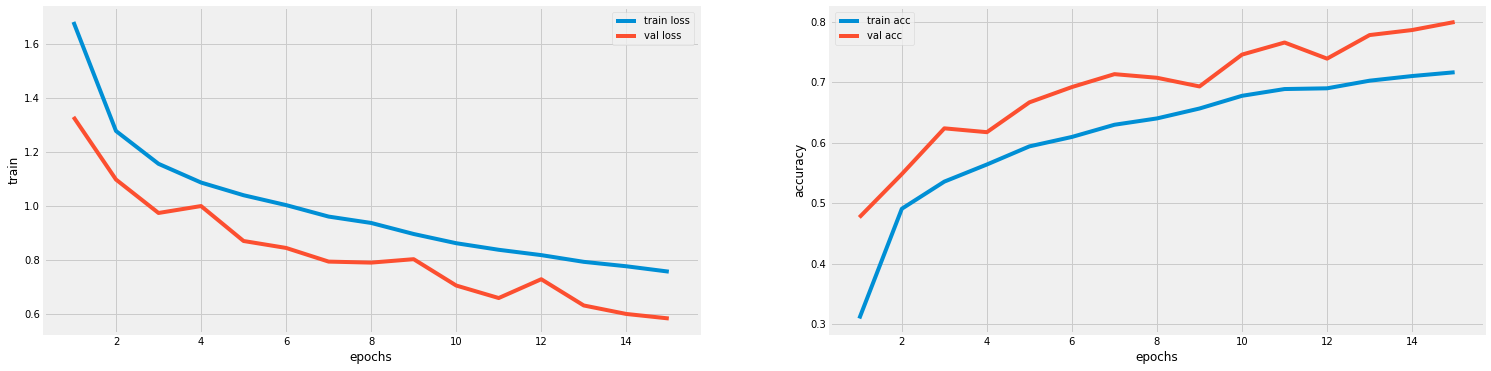

In [88]:
fig, ax= plt.subplots(1, 2, figsize=( 23, 6 ) )

sns.lineplot( data=intel_image_cls.metrics_df, y='train_loss', x='epoch', label='train loss', ax=ax[0])
sns.lineplot( data=intel_image_cls.metrics_df, y='val_loss', x='epoch', label='val loss', ax=ax[0])

sns.lineplot( data=intel_image_cls.metrics_df, y='train_acc', label='train acc', x='epoch', ax=ax[1])
sns.lineplot( data=intel_image_cls.metrics_df, y='val_acc', x='epoch', label='val acc', ax=ax[1])

ax[0].set( xlabel='epochs', ylabel='train')
ax[1].set( xlabel='epochs', ylabel='accuracy')

fig.savefig("metrics.jpg")


plt.show()

In [89]:
run['visual/acc_loss-fig'].upload(fig)

# Model load

In [ ]:
model = ConvNet()
model.load_state_dict( torch.load('/content/drive/MyDrive/ColabNotebooks/intel_image/model.pth')['model_state_dict'] )

<All keys matched successfully>

In [44]:
,next(model.parameters()).is_cuda

True

In [ ]:
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [ ]:
next(model.parameters()).is_cuda

True

# confusion matrix

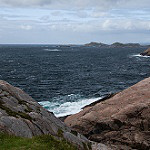

In [ ]:
image

In [ ]:
predicted_label = 0

In [ ]:
image=PIL.Image.open('/content/data/val/sea/20115.jpg')
    
image_tensor=data_transforms['val'](image).float()
image_tensor=image_tensor.unsqueeze_(0)
input=Variable(image_tensor)
input = input.to(device)
       
output_tensor = model(input)
predicted_values_tensor = output_tensor.data
predicted_values_ndarray = predicted_values_tensor.cpu().numpy()
index_of_max_values = predicted_values_ndarray.argmax()




predicted_label=class_names[index_of_max_values]
    
print( index_with_max_values )

print(class_names)
print( predicted_label)

3
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
mountain


In [ ]:
prediction( '/content/data/val/sea/20115.jpg', data_transforms['test'] )

'mountain'

In [ ]:
data_transforms['test'](image)

tensor([[[ 0.8863,  0.8392,  0.7922,  ...,  0.7137,  0.7137,  0.6980],
         [ 0.8863,  0.8078,  0.7451,  ...,  0.6824,  0.6667,  0.6667],
         [ 0.9020,  0.8549,  0.8235,  ...,  0.6510,  0.6510,  0.6510],
         ...,
         [-1.1843, -1.2314, -1.3412,  ..., -1.8588, -1.6863, -1.6863],
         [-1.1529, -1.1529, -1.2784,  ..., -1.7647, -1.9216, -1.6235],
         [-1.1843, -1.0745, -1.2314,  ..., -1.7490, -1.7804, -1.1686]],

        [[ 1.0745,  1.0275,  0.9804,  ...,  0.9804,  0.9804,  0.9490],
         [ 1.0745,  0.9961,  0.9333,  ...,  0.9490,  0.9333,  0.9176],
         [ 1.0902,  1.0431,  1.0118,  ...,  0.9176,  0.9176,  0.9020],
         ...,
         [-1.0431, -1.0431, -1.1373,  ..., -1.9686, -1.7961, -1.7961],
         [-1.0118, -0.9647, -1.0588,  ..., -1.8431, -2.0000, -1.7020],
         [-1.0588, -0.9333, -1.0431,  ..., -1.7961, -1.8275, -1.2157]],

        [[ 1.3255,  1.2784,  1.2314,  ...,  1.2941,  1.2941,  1.3098],
         [ 1.3255,  1.2471,  1.1843,  ...,  1

In [ ]:
data_transforms['test'](image).float()

tensor([[[ 0.8863,  0.8392,  0.7922,  ...,  0.7137,  0.7137,  0.6980],
         [ 0.8863,  0.8078,  0.7451,  ...,  0.6824,  0.6667,  0.6667],
         [ 0.9020,  0.8549,  0.8235,  ...,  0.6510,  0.6510,  0.6510],
         ...,
         [-1.1843, -1.2314, -1.3412,  ..., -1.8588, -1.6863, -1.6863],
         [-1.1529, -1.1529, -1.2784,  ..., -1.7647, -1.9216, -1.6235],
         [-1.1843, -1.0745, -1.2314,  ..., -1.7490, -1.7804, -1.1686]],

        [[ 1.0745,  1.0275,  0.9804,  ...,  0.9804,  0.9804,  0.9490],
         [ 1.0745,  0.9961,  0.9333,  ...,  0.9490,  0.9333,  0.9176],
         [ 1.0902,  1.0431,  1.0118,  ...,  0.9176,  0.9176,  0.9020],
         ...,
         [-1.0431, -1.0431, -1.1373,  ..., -1.9686, -1.7961, -1.7961],
         [-1.0118, -0.9647, -1.0588,  ..., -1.8431, -2.0000, -1.7020],
         [-1.0588, -0.9333, -1.0431,  ..., -1.7961, -1.8275, -1.2157]],

        [[ 1.3255,  1.2784,  1.2314,  ...,  1.2941,  1.2941,  1.3098],
         [ 1.3255,  1.2471,  1.1843,  ...,  1

In [ ]:
test_dir = '/content/data/test/test'

model_testing( images_dir= test_dir )

{'23646.jpg': 'buildings',
 '18326.jpg': 'street',
 '14402.jpg': 'glacier',
 '22419.jpg': 'sea',
 '18098.jpg': 'mountain',
 '15237.jpg': 'street',
 '14775.jpg': 'glacier',
 '22873.jpg': 'glacier',
 '20969.jpg': 'mountain',
 '16986.jpg': 'forest',
 '19064.jpg': 'sea',
 '2734.jpg': 'street',
 '9295.jpg': 'street',
 '10169.jpg': 'street',
 '2986.jpg': 'glacier',
 '2200.jpg': 'sea',
 '21211.jpg': 'street',
 '9949.jpg': 'forest',
 '18160.jpg': 'street',
 '5265.jpg': 'buildings',
 '7153.jpg': 'street',
 '20035.jpg': 'street',
 '5420.jpg': 'forest',
 '16766.jpg': 'mountain',
 '22743.jpg': 'buildings',
 '14524.jpg': 'glacier',
 '4376.jpg': 'street',
 '19881.jpg': 'mountain',
 '23438.jpg': 'sea',
 '14737.jpg': 'forest',
 '22155.jpg': 'glacier',
 '387.jpg': 'buildings',
 '15728.jpg': 'forest',
 '13554.jpg': 'mountain',
 '695.jpg': 'mountain',
 '12859.jpg': 'forest',
 '18613.jpg': 'mountain',
 '23517.jpg': 'mountain',
 '23493.jpg': 'mountain',
 '9523.jpg': 'sea',
 '4272.jpg': 'street',
 '4058.jpg

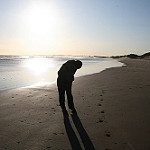

In [ ]:
image = cv2.imread( '/content/data/test/test/8094.jpg' )
cv2_imshow( image )

In [ ]:
files_gen = ( image for image in images_path  )

In [ ]:


image = cv2.imread( next( files_gen ) )
print( image.shape )
print( next( files_gen ) )
cv2_imshow( image )

In [ ]:
resize = cv2.resize(image, (0, 0), fx=2, fy=2 ) # 35% oryginalengo rozmiaru
print(f'Original image shape: {image.shape}' )
print(f'Resized image shape: {resize.shape}' )
cv2_imshow( resize )

In [ ]:
# Adding the text using putText() function
text = cv2.putText( resize,
                   'opis',
                   (50, 12),  # Bottom-left corner co-ordinates, from where the text should start
                   cv2.FONT_HERSHEY_SIMPLEX, # font
                   0.5,                        # font size
                   (255, 0, 0),
                   2)

cv2_imshow( text )

In [91]:
valloader = dataloaders['val']
valloader

In [ ]:
len( valloader )

In [ ]:
dataiter = iter( valloader )
images, labels = dataiter.next()

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in classes])

In [92]:
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d val images: %d %%' % (len(valloader),100 * correct / total))

Accuracy of the network on the 750 val images: 79 %


In [93]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in valloader:
        inputs = inputs.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


In [94]:
image_datasets['val'].class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

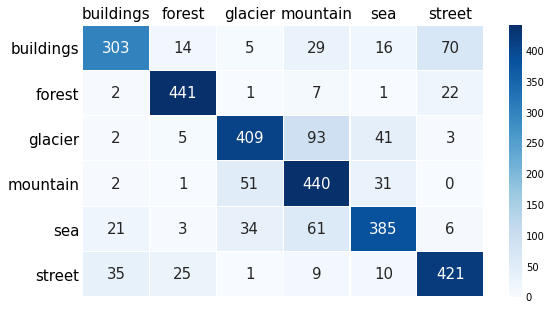

In [95]:
# constant for classes
classes = image_datasets['val'].classes

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 5))

cm_image = sns.heatmap( cm, annot=True, fmt='d', linewidth=.2, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 15})
cm_image.tick_params(labelsize=15)
cm_image.xaxis.tick_top()
plt.yticks(rotation=0) 
plt.xticks(rotation=0)

cm_image = cm_image.get_figure()

plt.show()

In [96]:
cm_image.savefig("confusion_matrix.jpg", bbox_inches='tight')

run['visual/confusion_matrix'].upload( cm_image )

In [97]:
fcls_report = classification_report(y_true, y_pred, target_names=classes)

print( cls_report )

              precision    recall  f1-score   support

   buildings       0.83      0.69      0.76       437
      forest       0.90      0.93      0.92       474
     glacier       0.82      0.74      0.78       553
    mountain       0.69      0.84      0.76       525
         sea       0.80      0.75      0.77       510
      street       0.81      0.84      0.82       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



In [98]:
cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

cls_report_df = pd.DataFrame( cls_report ).transpose()

cls_report_df

precision    recall  f1-score      support
buildings      0.830137  0.693364  0.755611   437.000000
forest         0.901840  0.930380  0.915888   474.000000
glacier        0.816367  0.739602  0.776091   553.000000
mountain       0.688576  0.838095  0.756014   525.000000
sea            0.795455  0.754902  0.774648   510.000000
street         0.806513  0.840319  0.823069   501.000000
accuracy       0.799667  0.799667  0.799667     0.799667
macro avg      0.806481  0.799444  0.800220  3000.000000
weighted avg   0.804314  0.799667  0.799282  3000.000000

In [99]:
frun['metrics/classification_report'].upload(File.as_html( cls_report_df ))

In [100]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.


All 4 operations synced, thanks for waiting!
